In [5]:
import mediapipe as mp
import cv2
import numpy as np
import matplotlib.pyplot as plt

# draw landmarks & connections to screen
mp_drawing = mp.solutions.drawing_utils
# import Pose model
mp_pose = mp.solutions.pose

In [6]:
def calc_angle(x, y, z):
    x = np.array(x)
    y = np.array(y)
    z = np.array(z)

    radians = np.arctan2(z[1]-y[1], z[0]-y[0]) - np.arctan2(x[1]-y[1], x[0]-y[0])
    angle = np.abs(radians * 180.0 / np.pi)

    if angle > 180.0:
        angle = 360 - angle

    return angle

In [8]:
def recognise_curl(detection):
    
    global counter
    global state
    global feedback
    global range_flag
    global left_angle
    global right_angle
    
    try:
        landmarks = detection.pose_landmarks.landmark
        
        # left arm
        left_wrist = [landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].x, landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].y]
        left_shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x, landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y]
        left_elbow = [landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].x, landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].y] 

        # right arm
        right_wrist = [landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value].y]
        right_shoulder = [landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].y]
        right_elbow = [landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].y]
        
        left_elbow_angle = calc_angle(left_shoulder, left_elbow, left_wrist)
        right_elbow_angle = calc_angle(right_shoulder, right_elbow, right_wrist)
        left_angle.append(int(left_elbow_angle))
        right_angle.append(int(right_elbow_angle))
        
        # down state
        if left_elbow_angle > 160 and right_elbow_angle > 160:
            if not range_flag:
                feedback = 'Did not curl completely.'
            else:
                feedback = 'Good rep!'
            state = 'Down'
            
        # not fully curled
        elif (left_elbow_angle > 50 and right_elbow_angle > 50) and state == 'Down':
            range_flag = False
            feedback = ''
            
        # up state
        elif (left_elbow_angle < 30 and right_elbow_angle < 30) and state == 'Down':
            state = 'Up'
            feedback = ''
            range_flag = True
            counter += 1
    
    except:
        left_angle.append(180)
        right_angle.append(180)

In [9]:
def recognise_squat(detection):
    
    global counter
    global state
    global feedback
    global left_angle
    global right_angle
       
    try:
        landmarks = detection.pose_landmarks.landmark
        
        # GET COORDINATES
        left_hip = [landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].x, landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].y]
        left_knee = [landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].x, landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].y]
        left_heel = [landmarks[mp_pose.PoseLandmark.LEFT_HEEL.value].x, landmarks[mp_pose.PoseLandmark.LEFT_HEEL.value].y]
        
        right_hip = [landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].y]
        right_knee = [landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].y]
        right_heel = [landmarks[mp_pose.PoseLandmark.RIGHT_HEEL.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_HEEL.value].y]
        
        left_shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x, landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y]
        right_shoulder = [landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].y]

        left = calc_angle(left_hip, left_knee, left_heel)
        right = calc_angle(right_hip, right_knee, right_heel)        
        left_angle.append(int(left))
        right_angle.append(int(right))
        
        #POSE CHECKING 1: Knees bending inwards    
        shoulder_dist = left_shoulder[0] - right_shoulder[0]
        knee_dist = left_knee[0] - right_knee[0]

        if shoulder_dist - knee_dist > 0.04:
            feedback = 'Open up your knees further apart to shoulder width!'
        else:
            feedback = ''

        # standing up
        if left > 170 and right > 170:
            state = "Up"
            
        if left < 165 and right < 165:
            feedback = 'Almost there... lower until height of hips!'
            
        if left < 140 and right < 140 and state == "Up":
            state = "Down"
            counter += 1
            
        if state == "Down":
            feedback = 'Good rep!'
    
    except:
        left_angle.append(180)
        right_angle.append(180)

In [10]:
def recognise_situp(detection):
    
    global counter
    global state
    global feedback
    global range_flag
    global halfway
    global body_angles
    
    try: 
        landmarks = detection.pose_landmarks.landmark
        
        left_hip = [landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].x, landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].y]
        left_knee = [landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].x, landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].y]
        left_heel = [landmarks[mp_pose.PoseLandmark.LEFT_HEEL.value].x, landmarks[mp_pose.PoseLandmark.LEFT_HEEL.value].y]
        left_shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x, landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y]

        # CALCULATE ANGLES 
        angle_knee = calc_angle(left_hip, left_knee, left_heel)
        angle_body = calc_angle(left_shoulder, left_hip, left_knee)
        body_angles.append(int(angle_body))
      
        if (angle_body < 80 and angle_body > 50) and state == "Down": #Half-way there (Used for checking bad situps)
            halfway = True

        if angle_body < 40 and state == "Down": #Complete situp
            state = "Up"
            range_flag = True
            
        if angle_body > 90 and angle_knee < 60: #Resting position;to check if situp was done properly
            state = "Down"
            
            if halfway: #Check if a rep was attempted
                if range_flag: #Check if a proper rep was performed
                    counter += 1
                    feedback = "Good repetition!"
                else:
                    feedback = "Did not perform sit up completely."
                range_flag = False #Reset vars
                halfway = False
                
        if angle_knee > 70: #Triggers anytime the legs are not tucked in
            feedback = "Keep legs tucked in closer"

    except: 
        body_angles.append(180)

In [11]:
def plot_viz(user_choice):
    
    # Set figure size
    plt.rcParams["figure.figsize"] = (20,5)
    
    # Squat viz
    if user_choice == 1:
        fig, ax = plt.subplots()
        ax.plot(frames, left_angle, '-', color = 'red', label = 'Left Knee Angle')
        ax.plot(frames, right_angle, '-', color = 'blue', label = 'Right Knee Angle')
        ax.axhline(y=140, color='g', linestyle='--')
        ax.legend(loc = 'center left')
        ax.set_xlabel('Frames')
        ax.set_ylabel('Angle')
        print(f'You managed {counter} squats!')
        
    # Curl viz
    elif user_choice == 2:
        fig, ax = plt.subplots()
        ax.plot(frames, left_angle, '-', color = 'red', label = 'Left Arm Angle')
        ax.plot(frames, right_angle, '-', color = 'blue', label = 'Right Arm Angle')
        ax.axhline(y=30, color='g', linestyle='--')
        ax.legend(loc = 'center left')
        ax.set_xlabel('Frames')
        ax.set_ylabel('Angle')
        print(f'You managed {counter} curls!')
        
    # Situp viz
    else:
        plt.plot(frames, body_angles, '-', color = 'red', label = 'Body Angle')
        plt.axhline(y=40, color='g', linestyle='--')
        plt.xlabel('Frames')
        plt.ylabel('Angle')
        print(f'You managed {counter} situps!')

Which exercise would you like to do?
1. Squat 
2. Curl 
3. Sit-up
2

You managed 0 curls!
The red/blue lines show the angle of your targetted body part throughout your exercise, whereas the green dotted line is the minimum angle required for the exercise to be recorded as one repetition.


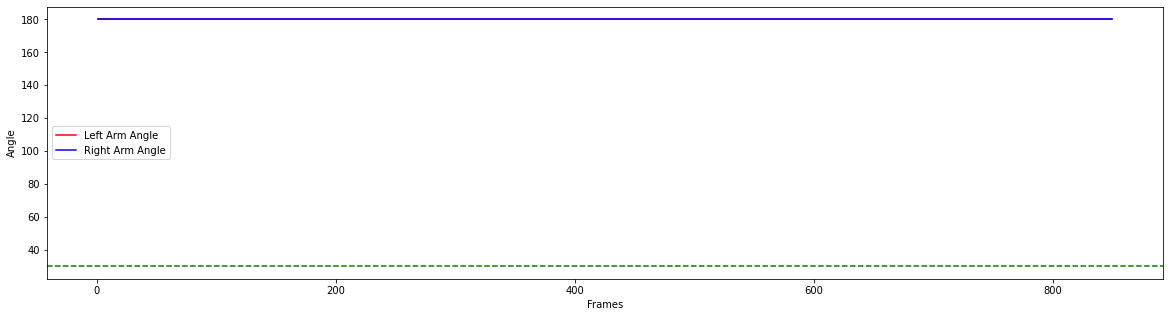

In [12]:
# initialise variables
counter = 0
state = 'Down'
range_flag = True
halfway = False
feedback = ''
frame_count = 0
# Plotting variables
frames = []
left_angle = []
right_angle = []
body_angles = []

# Prompt user input for exercise selection
while True:
    try:
        user_choice = int(input('Which exercise would you like to do?\n1. Squat \n2. Curl \n3. Sit-up\n'))
        print("")
        if user_choice in [1, 2, 3]:
            break
        else:
            print("Please enter either integer 1, 2 or 3")
            print("")
    except:
        print("Please enter either integer 1, 2 or 3")
        print("")

# Open webcam
feed = cv2.VideoCapture(0)

# Get user's maximum resolution
WIDTH = 10000
HEIGHT = 10000
feed.set(cv2.CAP_PROP_FRAME_WIDTH, WIDTH)
feed.set(cv2.CAP_PROP_FRAME_HEIGHT, HEIGHT)
width = int(feed.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(feed.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Mediapipe Pose model instance
with mp_pose.Pose(min_detection_confidence=50, min_tracking_confidence=50) as pose:
    while feed.isOpened():
        ret, frame = feed.read()
        frame_count += 1
        frames.append(frame_count)
        # Mirror frame
        frame = cv2.flip(frame, 1)
        # Recolor image from BGR to RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
        
        # Pose detection
        detection = pose.process(image)
        # Recolor image from RGB back to BGR
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image.flags.writeable = True

        # Render detections
        mp_drawing.draw_landmarks(image, detection.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
                                mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2))
        
        # Recognise particular exercise based on user input
        if user_choice == 1:
            recognise_squat(detection)
        elif user_choice == 2:
            recognise_curl(detection)
        else:
            recognise_situp(detection)
        

        # Status box setup
        cv2.rectangle(image, (0,0), (width, int(height*0.1)), (245,117,16), -1)
        cv2.putText(image, "REPS:", (int(width*0.01), int(height*0.025)), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA) # font, size, color, line width, line type
        
        cv2.putText(image, "STATE:", (int(width*0.1), int(height*0.025)), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
        
        cv2.putText(image, "FEEDBACK:", (int(width*0.2), int(height*0.025)), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
        
        cv2.putText(image, str(counter), (int(width*0.01), int(height*0.08)), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
        cv2.putText(image, state, (int(width*0.1), int(height*0.08)), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
        cv2.putText(image, feedback, (int(width*0.2), int(height*0.08)), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
        window_name = 'Exercise Counter'
        
        cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)
        cv2.imshow(window_name, image)
        
        # quit webcam
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cv2.destroyAllWindows()
cv2.waitKey(1)
feed.release()

plot_viz(user_choice)
print('The red/blue lines show the angle of your targetted body part throughout your exercise, whereas the green dotted line is the minimum angle required for the exercise to be recorded as one repetition.')


In [3]:
import cv2
import mediapipe as mp
import time
import math


In [1]:
pip install streamlit 

     ------------------                       4.2/9.1 MB 19.2 kB/s eta 0:04:15
Note: you may need to restart the kernel to use updated packages.


ERROR: Exception:
Traceback (most recent call last):
  File "C:\Users\Lenova\AppData\Roaming\Python\Python39\site-packages\pip\_vendor\urllib3\response.py", line 438, in _error_catcher
    yield
  File "C:\Users\Lenova\AppData\Roaming\Python\Python39\site-packages\pip\_vendor\urllib3\response.py", line 561, in read
    data = self._fp_read(amt) if not fp_closed else b""
  File "C:\Users\Lenova\AppData\Roaming\Python\Python39\site-packages\pip\_vendor\urllib3\response.py", line 527, in _fp_read
    return self._fp.read(amt) if amt is not None else self._fp.read()
  File "C:\Users\Lenova\AppData\Roaming\Python\Python39\site-packages\pip\_vendor\cachecontrol\filewrapper.py", line 90, in read
    data = self.__fp.read(amt)
  File "C:\Users\Lenova\anaconda3\lib\http\client.py", line 462, in read
    n = self.readinto(b)
  File "C:\Users\Lenova\anaconda3\lib\http\client.py", line 506, in readinto
    n = self.fp.readinto(b)
  File "C:\Users\Lenova\anaconda3\lib\socket.py", line 704, in readi

In [19]:

import cv2
import numpy as np
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_pose = mp.solutions.pose

In [20]:
def calculate_angle(a,b,c):
    a = np.array(a) # First
    b = np.array(b) # Mid
    c = np.array(c) # End
    
    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radians*180.0/np.pi)
    
    if angle >180.0:
        angle = 360-angle
        
    return angle

In [21]:

def rescale_frame(frame, percent=50):
    width = int(frame.shape[1] * percent/ 100)
    height = int(frame.shape[0] * percent/ 100)
    dim = (width, height)
    return cv2.resize(frame, dim, interpolation =cv2.INTER_AREA)

In [25]:

cap = cv2.VideoCapture(0)
# Curl counter variables
counter = 0 
stage = None



with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, frame = cap.read()
        
        # Recolor image to RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
      
        # Make detection
        results = pose.process(image)
    
        # Recolor back to BGR
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        # Extract landmarks
        try:
            landmarks = results.pose_landmarks.landmark
            
            # Get coordinates
            shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x,landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y]
            elbow = [landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].x,landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].y]
            wrist = [landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].x,landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].y]
            
            
            # Get coordinates
            hip = [landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].x,landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].y]
            knee = [landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].x,landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].y]
            ankle = [landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].x,landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].y]
            
           
            
            # Calculate angle
            angle = calculate_angle(shoulder, elbow, wrist)
            
            angle_knee = calculate_angle(hip, knee, ankle) #Knee joint angle
            
            angle_hip = calculate_angle(shoulder, hip, knee)
            hip_angle = 180-angle_hip
            knee_angle = 180-angle_knee
            
            # Visualize angle
            """cv2.putText(image, str(angle), 
                           tuple(np.multiply(elbow, [640, 480]).astype(int)), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA
                                )"""
            """        
                
            cv2.putText(image, str(angle_knee), 
                           tuple(np.multiply(knee, [640, 480]).astype(int)), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (79, 121, 66), 2, cv2.LINE_AA
                                )"""
            
            """cv2.putText(image, str(angle_hip), 
                           tuple(np.multiply(hip, [640, 480]).astype(int)), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA
                                )"""
            
            # Curl counter logic
            if angle_knee > 169:
                stage = "DOWN"
            if angle_knee <= 90 and stage =='DOWN':
                stage="UP"
                counter +=1
                print(counter)
        except:
            pass
        
        # Render squat counter
        # Setup status box
        cv2.rectangle(image, (0,0), (225,73), (245,117,16), -1)
        
        # Rep data
        cv2.putText(image, 'REPS', (15,12), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
        cv2.putText(image, str(counter), 
                    (10,60), 
                    cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 2, cv2.LINE_AA)
        
        # Stage data
        cv2.putText(image, 'STAGE', (65,12), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
        cv2.putText(image, stage, 
                    (60,60), 
                    cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 2, cv2.LINE_AA)
        
        
        # Render detections
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
                                mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2) 
                                 )               
        
        
        cv2.imshow('Squat', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    #out.release()
    cv2.destroyAllWindows()
    


1
2
3


In [4]:
pip install playsound


  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for playsound: filename=playsound-1.3.0-py3-none-any.whl size=7035 sha256=39d457ea2b96fa17d4df88e5ebaddc04b906f59a388e1269917e9b302d87e78d
  Stored in directory: c:\users\lenova\appdata\local\pip\cache\wheels\ba\39\54\c8f7ff9a88a644d3c58b4dec802d90b79a2e0fb2a6b884bf82
Successfully built playsound
Note: you may need to restart the kernel to use updated packages.


In [4]:
import cv2
import mediapipe as mp
import numpy as np
from gtts import gTTS
from playsound import  playsound
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

def checkHandInBox(handX, handY, tlX, tlY, brX, brY):
    if handX>tlX and handX<brX and handY>tlY and handY<brY:
        return True
    else:
        return False

def createMenu():
    cv2.destroyAllWindows()

    cap = cv2.VideoCapture(0)

    curlTlx=220;curlBrx=400;curlTly=100;curlBry=160
    deadliftTlx=220;deadliftBrx=400;deadliftTly=200;deadliftBry=260
    squatTlx=220;squatBrx=400;squatTly=300;squatBry=360

    with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
        while cap.isOpened():
            ret, frame = cap.read()
            
            # Recolor image to RGB
            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            image.flags.writeable = False
        
            # Make detection
            results = pose.process(image)
            # Recolor back to BGR
            image.flags.writeable = True
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)


            try:
                landmarks = results.pose_landmarks.landmark
                
                # Get coordinates

                leftHand = [landmarks[mp_pose.PoseLandmark.LEFT_INDEX.value].x,landmarks[mp_pose.PoseLandmark.LEFT_PINKY.value].y]
                rightHand = [landmarks[mp_pose.PoseLandmark.RIGHT_INDEX.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_PINKY.value].y]

                if(checkHandInBox(leftHand[0]*640,leftHand[1]*480 ,curlTlx, curlTly, curlBrx, curlBry) or checkHandInBox(rightHand[0]*640,rightHand[1]*480 ,curlTlx, curlTly, curlBrx, curlBry)):
                    cap.release()
                    cv2.destroyAllWindows()
                    curl()
                    break

                if(checkHandInBox(leftHand[0]*640,leftHand[1]*480 ,deadliftTlx, deadliftTly, deadliftBrx, deadliftBry) or checkHandInBox(rightHand[0]*640,rightHand[1]*480 ,deadliftTlx, deadliftTly, deadliftBrx, deadliftBry)):
                    cap.release()
                    cv2.destroyAllWindows()
                    deadlift()
                    break

                if(checkHandInBox(leftHand[0]*640,leftHand[1]*480 ,squatTlx, squatTly, squatBrx, squatBry) or checkHandInBox(rightHand[0]*640,rightHand[1]*480 ,squatTlx, squatTly, squatBrx, squatBry)):
                    cap.release()
                    cv2.destroyAllWindows()
                    squat()
                    break
                        
            except:
                pass

            # curlTlx=220;curlBrx=400;curlTly=200;curlBry=260
            cv2.rectangle(image, (curlTlx,curlTly), (curlBrx,curlBry), (245,117,16), -1)
            cv2.putText(image, 'BICEP CURL', (220,160), 
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 1, cv2.LINE_AA)
            # deadliftTlx=220;deadliftBrx=400;deadliftTly=300;deadliftBry=360
            cv2.rectangle(image, (deadliftTlx,deadliftTly), (deadliftBrx,deadliftBry), (245,117,16), -1)
            cv2.putText(image, 'DEADLIFT', (220,260), 
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 1, cv2.LINE_AA)
            # squatTlx=220;squatBrx=400;squatTly=400;squatBry=460
            cv2.rectangle(image, (squatTlx,squatTly), (squatBrx,squatBry), (245,117,16), -1)
            cv2.putText(image, 'SQUAT', (220,360), 
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 1, cv2.LINE_AA)

            mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                    mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
                                    mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2) 
                                    )  
            cv2.imshow('Mediapipe Feed', image)
            if cv2.waitKey(10) & 0xFF == ord('q'):
                break

    cap.release()
    cv2.destroyAllWindows()


def calculate_angle(a,b,c):
    a = np.array(a) # First
    b = np.array(b) # Mid
    c = np.array(c) # End
    
    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radians*180.0/np.pi)
    
    if angle >180.0:
        angle = 360-angle
        
    return angle 


def curl():
    cv2.destroyAllWindows()

    cap = cv2.VideoCapture(0)

    # Curl counter variables
    counter = 0 
    stage = None

    ## Setup mediapipe instance
    with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
        while cap.isOpened():
            ret, frame = cap.read()
            
            # Recolor image to RGB
            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            image.flags.writeable = False
        
            # Make detection
            results = pose.process(image)
        
            # Recolor back to BGR
            image.flags.writeable = True
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
            
            # Extract landmarks
            try:
                landmarks = results.pose_landmarks.landmark
                
                # Get coordinates
                shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x,landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y]
                elbow = [landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].x,landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].y]
                wrist = [landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].x,landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].y]

                leftHand = [landmarks[mp_pose.PoseLandmark.LEFT_INDEX.value].x,landmarks[mp_pose.PoseLandmark.LEFT_PINKY.value].y]
                rightHand = [landmarks[mp_pose.PoseLandmark.RIGHT_INDEX.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_PINKY.value].y]

                if(checkHandInBox(leftHand[0]*640,leftHand[1]*480 ,590,20,670,80) or checkHandInBox(rightHand[0]*640,rightHand[1]*480,600,0,680,60)):
                    cap.release()
                    cv2.destroyAllWindows()
                    createMenu()
                    break
                
                # Calculate angle
                angle = calculate_angle(shoulder, elbow, wrist)
                
                # Visualize angle
                cv2.putText(image, str(angle), 
                            tuple(np.multiply(elbow, [640, 480]).astype(int)), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA
                                    )
                
                # Curl counter logic
                if angle > 160:
                    stage = "down"
                if angle < 30 and stage =='down':
                    stage="up"
                    counter +=1
                    mytext=str(counter)
                    language='en'
                    myobj=gTTS(text=mytext,lang=language,slow=True)
                    # myobj.save("welcome1.mp3")
                    # playsound("welcome1.mp3")
                    myobj.save("welcome"+str(counter)+".mp3")
                    playsound("welcome"+str(counter)+".mp3")
                    print(counter)
                        
            except:
                pass
            
            # Render curl counter
            # Setup status box
            cv2.rectangle(image, (0,0), (240,73), (245,117,16), -1)
            cv2.rectangle(image, (590,20), (670,80), (245,117,16), -1)
            cv2.putText(image, 'S', (590,79), 
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 1, cv2.LINE_AA)
            
            # Rep data
            cv2.putText(image, 'REPS', (15,12), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
            cv2.putText(image, str(counter), 
                        (10,60), 
                        cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 2, cv2.LINE_AA)
            # cv2.putText(image, 'CURL', 
            #             (480,60), 
            #             cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 2, cv2.LINE_AA)
            
            # Stage data
            cv2.putText(image, 'STAGE', (85,12), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
            cv2.putText(image, stage, 
                        (80,60), 
                        cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 2, cv2.LINE_AA)
            
            
            # Render detections
            mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                    mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
                                    mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2) 
                                    )               
            
            cv2.imshow('Mediapipe Feed', image)

            if cv2.waitKey(10) & 0xFF == ord('q'):
                break

        cap.release()
        cv2.destroyAllWindows()


def checkDeadlift(a,b,c,d,checkUp=False):
    if c.visibility>0.5 and d.visibility>0.5:
        print("visible")
        if checkUp==True:
            if a.y<c.y and b.y<d.y:
                return True
            else:
                return False
        else:
            if a.y>c.y and b.y>d.y:
                return True
            else:
                return False
    else:
        print("not visible")
        return False


def deadlift():
    cv2.destroyAllWindows()

    cap = cv2.VideoCapture(0)

    # Deadlift counter variables
    counter = 0 
    stage = None

    ## Setup mediapipe instance
    with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
        while cap.isOpened():
            ret, frame = cap.read()
            
            # Recolor image to RGB
            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            image.flags.writeable = False
        
            # Make detection
            results = pose.process(image)
        
            # Recolor back to BGR
            image.flags.writeable = True
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
            
            # Extract landmarks
            try:
                landmarks = results.pose_landmarks.landmark

                # left_hand = landmarks[mp_pose.PoseLandmark.LEFT_INDEX.value]
                # right_hand = landmarks[mp_pose.PoseLandmark.RIGHT_INDEX.value]
                # left_knee = landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value]
                # right_knee = landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value]

                leftHand = [landmarks[mp_pose.PoseLandmark.LEFT_INDEX.value].x,landmarks[mp_pose.PoseLandmark.LEFT_PINKY.value].y]
                rightHand = [landmarks[mp_pose.PoseLandmark.RIGHT_INDEX.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_PINKY.value].y]

                if(checkHandInBox(leftHand[0]*640,leftHand[1]*480 ,590,20,670,80) or checkHandInBox(rightHand[0]*640,rightHand[1]*480,600,0,680,60)):
                    cap.release()
                    cv2.destroyAllWindows()
                    createMenu()
                    break

                left_hand = landmarks[mp_pose.PoseLandmark.LEFT_INDEX.value]
                right_hand = landmarks[mp_pose.PoseLandmark.RIGHT_INDEX.value]
                left_knee = landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value]
                right_knee = landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value]

                if checkDeadlift(left_hand,right_hand,left_knee,right_knee):
                    stage = "down"
                if stage=="down" and checkDeadlift(left_hand,right_hand,left_knee,right_knee,checkUp=True):
                    stage="up"
                    counter+=1
                    mytext=str(counter)
                    language='en'
                    myobj=gTTS(text=mytext,lang=language,slow=True)
                    myobj.save("welcome"+str(counter)+".mp3")
                    playsound("welcome"+str(counter)+".mp3")
                    print(counter)
                        
            except:
                pass
            
            # Setup status box
            cv2.rectangle(image, (0,0), (240,73), (245,117,16), -1)
            cv2.rectangle(image, (590,20), (670,80), (245,117,16), -1)
            cv2.putText(image, 'S', (590,79), 
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 1, cv2.LINE_AA)
            
            # Rep data
            cv2.putText(image, 'REPS', (15,12), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
            cv2.putText(image, str(counter), 
                        (10,60), 
                        cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 2, cv2.LINE_AA)
            # cv2.putText(image, 'DEADLIFT', 
            #             (460,60), 
            #             cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 2, cv2.LINE_AA)
            
            # Stage data
            cv2.putText(image, 'STAGE', (85,12), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
            cv2.putText(image, stage, 
                        (80,60), 
                        cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 2, cv2.LINE_AA)
            
            
            # Render detections
            mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                    mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
                                    mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2) 
                                    )               
            
            cv2.imshow('Mediapipe Feed', image)

            if cv2.waitKey(10) & 0xFF == ord('q'):
                break

        cap.release()
        cv2.destroyAllWindows()

def checkSquat(a,b,c,d,checkUp=False):
    if a.visibilty>0.4 and b.visibility>0.4 and c.visibility>0.4 and d.visibility>0.4:
        print("visible")
        # Cup20=c.y+c.y*0.2
        Cdown30=c.y-c.y*0.6
        # Dup20=d.y+d.y*0.2
        Ddown30=d.y-d.y*0.6
        if checkUp==True:
            if a.y<Cdown30 and b.y<Ddown30:
                return True
            else:
                return False
        else:
            if a.y>Cdown30 and b.y>Ddown30:
                return True
            else:
                return False
    else:
        print("not visible")
        return False


def squat():
    cv2.destroyAllWindows()
    cap = cv2.VideoCapture(0)

    # Deadlift counter variables
    counter = 0 
    stage = "None"

    ## Setup mediapipe instance
    with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
        while cap.isOpened():
            ret, frame = cap.read()
            
            # Recolor image to RGB
            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            image.flags.writeable = False
        
            # Make detection
            results = pose.process(image)
        
            # Recolor back to BGR
            image.flags.writeable = True
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
            
            # Extract landmarks
            try:
                landmarks = results.pose_landmarks.landmark

                left_hip = landmarks[mp_pose.PoseLandmark.LEFT_HIP.value]
                right_hip = landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value]
                left_knee = landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value]
                right_knee = landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value]

                leftHand = [landmarks[mp_pose.PoseLandmark.LEFT_INDEX.value].x,landmarks[mp_pose.PoseLandmark.LEFT_PINKY.value].y]
                rightHand = [landmarks[mp_pose.PoseLandmark.RIGHT_INDEX.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_PINKY.value].y]

                if(checkHandInBox(leftHand[0]*640,leftHand[1]*480 ,590,20,670,80) or checkHandInBox(rightHand[0]*640,rightHand[1]*480,600,0,680,60)):
                    cap.release()
                    cv2.destroyAllWindows()
                    createMenu()
                    break

                if checkSquat(left_hip,right_hip,left_knee,right_knee):
                    stage = "down"
                if stage=="down" and checkSquat(left_hip,right_hip,left_knee,right_knee,checkUp=True):
                    stage="up"
                    counter+=1
                    mytext=str(counter)
                    language='en'
                    myobj=gTTS(text=mytext,lang=language,slow=True)
                    myobj.save("welcome"+str(counter)+".mp3")
                    playsound("welcome"+str(counter)+".mp3")
                    print(counter)
                        
            except:
                pass
            
            # Setup status box
            cv2.rectangle(image, (0,0), (240,73), (245,117,16), -1)
            cv2.rectangle(image, (590,20), (670,80), (245,117,16), -1)
            cv2.putText(image, 'S', (590,79), 
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 1, cv2.LINE_AA)
            
            # Rep data
            cv2.putText(image, 'REPS', (15,12), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
            cv2.putText(image, str(counter), 
                        (10,60), 
                        cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 2, cv2.LINE_AA)
            
            # Stage data
            cv2.putText(image, 'STAGE', (85,12), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
            cv2.putText(image, stage, 
                        (80,60), 
                        cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 2, cv2.LINE_AA)
            # cv2.putText(image, 'SQUAT', 
            #             (470,60), 
            #             cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 2, cv2.LINE_AA)
            
            
            # Render detections
            mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                    mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
                                    mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2) 
                                    )               
            
            cv2.imshow('Mediapipe Feed', image)

            if cv2.waitKey(10) & 0xFF == ord('q'):
                break

        cap.release()
        cv2.destroyAllWindows()

createMenu()


    Error 263 for command:
        open welcome1.mp3
    The specified device is not open or is not recognized by MCI.

    Error 263 for command:
        close welcome1.mp3
    The specified device is not open or is not recognized by MCI.
Failed to close the file: welcome1.mp3


2



    Error 263 for command:
        open welcome3.mp3
    The specified device is not open or is not recognized by MCI.

    Error 263 for command:
        close welcome3.mp3
    The specified device is not open or is not recognized by MCI.
Failed to close the file: welcome3.mp3


4



    Error 263 for command:
        open welcome5.mp3
    The specified device is not open or is not recognized by MCI.

    Error 263 for command:
        close welcome5.mp3
    The specified device is not open or is not recognized by MCI.
Failed to close the file: welcome5.mp3


6



    Error 263 for command:
        open welcome7.mp3
    The specified device is not open or is not recognized by MCI.

    Error 263 for command:
        close welcome7.mp3
    The specified device is not open or is not recognized by MCI.
Failed to close the file: welcome7.mp3


8
9



    Error 259 for command:
        play welcome10.mp3 wait
    The driver cannot recognize the specified command parameter.

    Error 263 for command:
        close welcome10.mp3
    The specified device is not open or is not recognized by MCI.
Failed to close the file: welcome10.mp3

    Error 259 for command:
        play welcome11.mp3 wait
    The driver cannot recognize the specified command parameter.

    Error 263 for command:
        close welcome11.mp3
    The specified device is not open or is not recognized by MCI.
Failed to close the file: welcome11.mp3

    Error 263 for command:
        open welcome12.mp3
    The specified device is not open or is not recognized by MCI.

    Error 263 for command:
        close welcome12.mp3
    The specified device is not open or is not recognized by MCI.
Failed to close the file: welcome12.mp3

    Error 263 for command:
        open welcome13.mp3
    The specified device is not open or is not recognized by MCI.

    Error 263 for com

not visible
not visible
not visible
not visible
not visible
not visible
not visible
not visible
not visible
not visible
not visible
not visible
not visible
not visible
not visible
not visible
not visible
not visible
not visible
not visible
not visible
not visible
not visible
not visible
not visible
not visible
not visible
not visible
not visible
not visible
not visible
not visible
not visible
not visible
not visible
not visible
not visible
not visible
not visible
not visible
not visible
not visible
not visible
not visible
not visible
not visible
not visible
not visible
not visible
not visible
not visible
not visible
not visible
not visible
not visible
not visible
not visible
not visible
not visible
not visible
not visible
not visible
not visible
not visible
not visible
not visible
not visible
not visible
not visible
not visible
not visible
not visible
not visible
not visible
not visible
not visible
not visible
not visible
not visible
not visible
not visible
not visible
not visible
not 


    Error 263 for command:
        open welcome1.mp3
    The specified device is not open or is not recognized by MCI.

    Error 263 for command:
        close welcome1.mp3
    The specified device is not open or is not recognized by MCI.
Failed to close the file: welcome1.mp3

    Error 263 for command:
        open welcome2.mp3
    The specified device is not open or is not recognized by MCI.

    Error 263 for command:
        close welcome2.mp3
    The specified device is not open or is not recognized by MCI.
Failed to close the file: welcome2.mp3

    Error 263 for command:
        open welcome1.mp3
    The specified device is not open or is not recognized by MCI.

    Error 263 for command:
        close welcome1.mp3
    The specified device is not open or is not recognized by MCI.
Failed to close the file: welcome1.mp3

    Error 263 for command:
        open welcome2.mp3
    The specified device is not open or is not recognized by MCI.

    Error 263 for command:
        clos

Which exercise would you like to do?
1. Squat 
2. Curl 
3. Sit-up
2

You managed 0 curls!


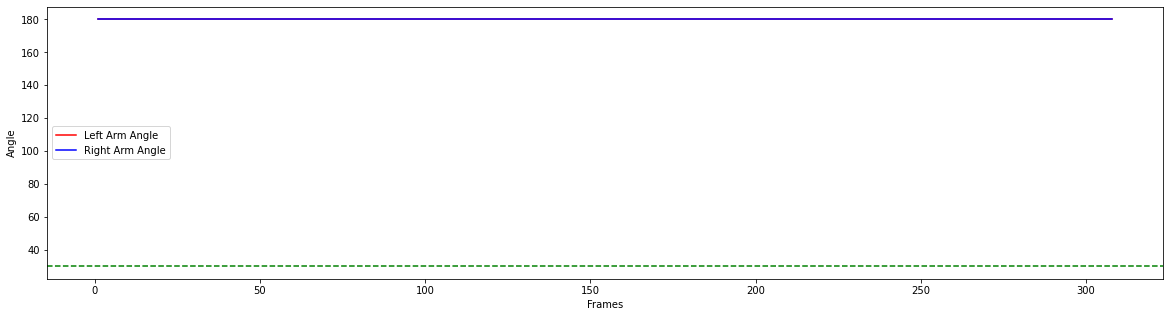

In [1]:
import mediapipe as mp
import cv2
import numpy as np
import matplotlib.pyplot as plt

# draw landmarks & connections to screen
mp_drawing = mp.solutions.drawing_utils
# import Pose model
mp_pose = mp.solutions.pose
def calc_angle(x, y, z):
    x = np.array(x)
    y = np.array(y)
    z = np.array(z)

    radians = np.arctan2(z[1]-y[1], z[0]-y[0]) - np.arctan2(x[1]-y[1], x[0]-y[0])
    angle = np.abs(radians * 180.0 / np.pi)

    if angle > 180.0:
        angle = 360 - angle

    return angle
def recognise_curl(detection):
    
    global counter
    global state
    global feedback
    global range_flag
    global left_angle
    global right_angle
    
    try:
        landmarks = detection.pose_landmarks.landmark
        
        # left arm
        left_wrist = [landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].x, landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].y]
        left_shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x, landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y]
        left_elbow = [landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].x, landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].y] 

        # right arm
        right_wrist = [landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value].y]
        right_shoulder = [landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].y]
        right_elbow = [landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].y]
        
        left_elbow_angle = calc_angle(left_shoulder, left_elbow, left_wrist)
        right_elbow_angle = calc_angle(right_shoulder, right_elbow, right_wrist)
        left_angle.append(int(left_elbow_angle))
        right_angle.append(int(right_elbow_angle))
        
        # down state
        if left_elbow_angle > 160 and right_elbow_angle > 160:
            if not range_flag:
                feedback = 'Did not curl completely.'
            else:
                feedback = 'Good rep!'
            state = 'Down'
            
        # not fully curled
        elif (left_elbow_angle > 50 and right_elbow_angle > 50) and state == 'Down':
            range_flag = False
            feedback = ''
            
        # up state
        elif (left_elbow_angle < 30 and right_elbow_angle < 30) and state == 'Down':
            state = 'Up'
            feedback = ''
            range_flag = True
            counter += 1
    
    except:
        left_angle.append(180)
        right_angle.append(180)
def recognise_squat(detection):
    
    global counter
    global state
    global feedback
    global left_angle
    global right_angle
       
    try:
        landmarks = detection.pose_landmarks.landmark
        
        # GET COORDINATES
        left_hip = [landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].x, landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].y]
        left_knee = [landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].x, landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].y]
        left_heel = [landmarks[mp_pose.PoseLandmark.LEFT_HEEL.value].x, landmarks[mp_pose.PoseLandmark.LEFT_HEEL.value].y]
        
        right_hip = [landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].y]
        right_knee = [landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].y]
        right_heel = [landmarks[mp_pose.PoseLandmark.RIGHT_HEEL.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_HEEL.value].y]
        
        left_shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x, landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y]
        right_shoulder = [landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].y]

        left = calc_angle(left_hip, left_knee, left_heel)
        right = calc_angle(right_hip, right_knee, right_heel)        
        left_angle.append(int(left))
        right_angle.append(int(right))
        
        #POSE CHECKING 1: Knees bending inwards    
        shoulder_dist = left_shoulder[0] - right_shoulder[0]
        knee_dist = left_knee[0] - right_knee[0]

        if shoulder_dist - knee_dist > 0.04:
            feedback = 'Open up your knees further apart to shoulder width!'
        else:
            feedback = ''

        # standing up
        if left > 170 and right > 170:
            state = "Up"
            
        if left < 165 and right < 165:
            feedback = 'Almost there... lower until height of hips!'
            
        if left < 140 and right < 140 and state == "Up":
            state = "Down"
            counter += 1
            
        if state == "Down":
            feedback = 'Good rep!'
    
    except:
        left_angle.append(180)
        right_angle.append(180)
def recognise_situp(detection):
    
    global counter
    global state
    global feedback
    global range_flag
    global halfway
    global body_angles
    
    try: 
        landmarks = detection.pose_landmarks.landmark
        
        left_hip = [landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].x, landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].y]
        left_knee = [landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].x, landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].y]
        left_heel = [landmarks[mp_pose.PoseLandmark.LEFT_HEEL.value].x, landmarks[mp_pose.PoseLandmark.LEFT_HEEL.value].y]
        left_shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x, landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y]

        # CALCULATE ANGLES 
        angle_knee = calc_angle(left_hip, left_knee, left_heel)
        angle_body = calc_angle(left_shoulder, left_hip, left_knee)
        body_angles.append(int(angle_body))
      
        if (angle_body < 80 and angle_body > 50) and state == "Down": #Half-way there (Used for checking bad situps)
            halfway = True

        if angle_body < 40 and state == "Down": #Complete situp
            state = "Up"
            range_flag = True
            
        if angle_body > 90 and angle_knee < 60: #Resting position;to check if situp was done properly
            state = "Down"
            
            if halfway: #Check if a rep was attempted
                if range_flag: #Check if a proper rep was performed
                    counter += 1
                    feedback = "Good repetition!"
                else:
                    feedback = "Did not perform sit up completely."
                range_flag = False #Reset vars
                halfway = False
                
        if angle_knee > 70: #Triggers anytime the legs are not tucked in
            feedback = "Keep legs tucked in closer"

    except: 
        body_angles.append(180)
def plot_viz(user_choice):
    
    # Set figure size
    plt.rcParams["figure.figsize"] = (20,5)
    
    # Squat viz
    if user_choice == 1:
        fig, ax = plt.subplots()
        ax.plot(frames, left_angle, '-', color = 'red', label = 'Left Knee Angle')
        ax.plot(frames, right_angle, '-', color = 'blue', label = 'Right Knee Angle')
        ax.axhline(y=140, color='g', linestyle='--')
        ax.legend(loc = 'center left')
        ax.set_xlabel('Frames')
        ax.set_ylabel('Angle')
        print(f'You managed {counter} squats!')
        
    # Curl viz
    elif user_choice == 2:
        fig, ax = plt.subplots()
        ax.plot(frames, left_angle, '-', color = 'red', label = 'Left Arm Angle')
        ax.plot(frames, right_angle, '-', color = 'blue', label = 'Right Arm Angle')
        ax.axhline(y=30, color='g', linestyle='--')
        ax.legend(loc = 'center left')
        ax.set_xlabel('Frames')
        ax.set_ylabel('Angle')
        print(f'You managed {counter} curls!')
        
    # Situp viz
    else:
        plt.plot(frames, body_angles, '-', color = 'red', label = 'Body Angle')
        plt.axhline(y=40, color='g', linestyle='--')
        plt.xlabel('Frames')
        plt.ylabel('Angle')
        print(f'You managed {counter} situps!')
# initialise variables
counter = 0
state = 'Down'
range_flag = True
halfway = False
feedback = ''
frame_count = 0
# Plotting variables
frames = []
left_angle = []
right_angle = []
body_angles = []

# Prompt user input for exercise selection
while True:
    try:
        user_choice = int(input('Which exercise would you like to do?\n1. Squat \n2. Curl \n3. Sit-up\n'))
        print("")
        if user_choice in [1, 2, 3]:
            break
        else:
            print("Please enter either integer 1, 2 or 3")
            print("")
    except:
        print("Please enter either integer 1, 2 or 3")
        print("")

# Open webcam
feed = cv2.VideoCapture(0)

# Get user's maximum resolution
WIDTH = 10000
HEIGHT = 10000
feed.set(cv2.CAP_PROP_FRAME_WIDTH, WIDTH)
feed.set(cv2.CAP_PROP_FRAME_HEIGHT, HEIGHT)
width = int(feed.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(feed.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Mediapipe Pose model instance
with mp_pose.Pose(min_detection_confidence=50, min_tracking_confidence=50) as pose:
    while feed.isOpened():
        ret, frame = feed.read()
        frame_count += 1
        frames.append(frame_count)
        # Mirror frame
        frame = cv2.flip(frame, 1)
        # Recolor image from BGR to RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
        
        # Pose detection
        detection = pose.process(image)
        # Recolor image from RGB back to BGR
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image.flags.writeable = True

        # Render detections
        mp_drawing.draw_landmarks(image, detection.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
                                mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2))
        
        # Recognise particular exercise based on user input
        if user_choice == 1:
            recognise_squat(detection)
        elif user_choice == 2:
            recognise_curl(detection)
        else:
            recognise_situp(detection)
        

        # Status box setup
        cv2.rectangle(image, (0,0), (width, int(height*0.1)), (245,117,16), -1)
        cv2.putText(image, "REPS:", (int(width*0.01), int(height*0.025)), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA) # font, size, color, line width, line type
        
        cv2.putText(image, "STATE:", (int(width*0.1), int(height*0.025)), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
        
        cv2.putText(image, "FEEDBACK:", (int(width*0.2), int(height*0.025)), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
        
        cv2.putText(image, str(counter), (int(width*0.01), int(height*0.08)), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
        cv2.putText(image, state, (int(width*0.1), int(height*0.08)), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
        cv2.putText(image, feedback, (int(width*0.2), int(height*0.08)), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
        window_name = 'Exercise Counter'
        
        cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)
        cv2.imshow(window_name, image)
        
        # quit webcam
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cv2.destroyAllWindows()
cv2.waitKey(1)
feed.release()

plot_viz(user_choice)

In [1]:
pip install pyttsx3


Note: you may need to restart the kernel to use updated packages.


In [6]:
import pyttsx3

engine = pyttsx3.init()

def speak(text):
    engine.say(text)
    engine.runAndWait()


In [7]:
pip install threading


Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement threading (from versions: none)
ERROR: No matching distribution found for threading
